In [60]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import os
import json
import sys
sys.path.append('..')

from sleeprnn.data import utils

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

In [50]:
example_id = 3

fs = 200

path_data = os.path.abspath('../resources/datasets/dreams_ss')
path_register = os.path.join(path_data, 'register')
path_spindle = os.path.join(path_data, 'label/spindle')
path_state = os.path.join(path_data, 'label/state')

# Load files
signal_fn = os.path.join(path_register, 'excerpt%d.txt' % example_id)
spindle_fn = os.path.join(path_spindle, 'Visual_scoring1_excerpt%d.txt' % example_id)
state_fn = os.path.join(path_state, 'Hypnogram_excerpt%d.txt' % example_id)

# Load sampling frequencies
with open(os.path.join(path_data, 'fs_spindle.json'), 'r') as handle:
    fs_spindle = json.load(handle)
fs_original = fs_spindle['excerpt%d' % example_id]
print('Original sampling frequency %d' % fs_original)

print('Loading %s' % signal_fn)
signal = np.loadtxt(signal_fn, skiprows=1)
if fs_original != fs:
    signal_resampled = utils.resample_signal(signal, fs_original, fs)
else:
    signal_resampled = signal.copy()

print('Loading %s' % spindle_fn)
ss_stamps = np.loadtxt(spindle_fn, skiprows=1)  # in seconds [start, duration]
ss_stamps = np.stack([ss_stamps[:, 0], ss_stamps.sum(axis=1)], axis=1)  # Transform to [start, end] in seconds
print('Number of events:', ss_stamps.shape[0])

"""
These numerical values correspond to the sleep stage (one value per 5 sec) annotated by the expert according to the Rechtschaffen and Kales criteria.
5=wake
4=REM stage
3=sleep stage S1
2=sleep stage S2
1=sleep stage S3
0=sleep stage S4
-1=sleep stage movement
-2 or -3 =unknow sleep stage """

print('Loading %s' % state_fn)
state = np.loadtxt(state_fn, skiprows=1)
# Transform annotations every 5s to annotations every 20s (RK)
n_pages = int(state.size/4)
state_rk = np.zeros(n_pages, dtype=np.int32)
for i in range(n_pages):
    state_rk[i] = int(np.mean(state[4*i:4*(i+1)]))
print('Number of 20s pages:', state_rk.size)

Original sampling frequency 50
Loading /home/ntapia/Projects/GitNico/sleep-rnn/resources/datasets/dreams_ss/register/excerpt3.txt
Loading /home/ntapia/Projects/GitNico/sleep-rnn/resources/datasets/dreams_ss/label/spindle/Visual_scoring1_excerpt3.txt
Number of events: 5
Loading /home/ntapia/Projects/GitNico/sleep-rnn/resources/datasets/dreams_ss/label/state/Hypnogram_excerpt3.txt
Number of 20s pages: 90


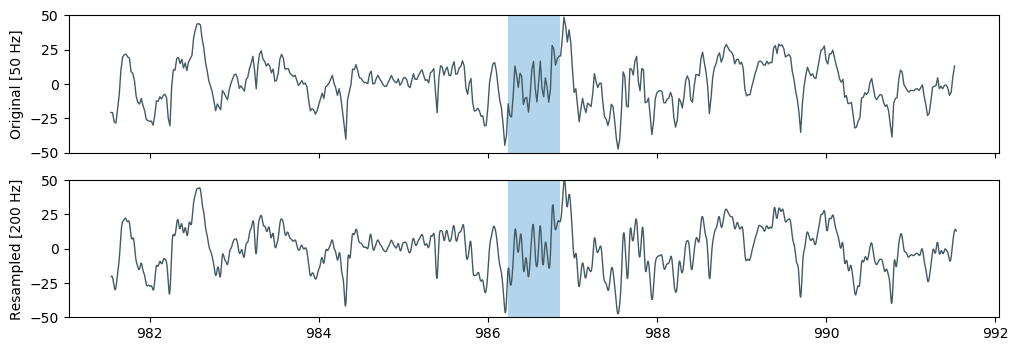

In [78]:
# Show signal
which_stamp = 4

center_time = ss_stamps[which_stamp, :].mean()
start_time = center_time - 5
end_time = center_time + 5

fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=100, sharex=True)

max_y = 50

start_sample = int(start_time*fs_original)
end_sample = int(end_time*fs_original)
time_axis = np.arange(signal.size) / fs_original
ax[0].plot(time_axis[start_sample:end_sample], signal[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
ax[0].fill_between(ss_stamps[which_stamp, :], max_y, -max_y, alpha=0.3, facecolor=CUSTOM_COLOR['blue'])
ax[0].set_ylabel('Original [%d Hz]' % fs_original)
ax[0].set_ylim([-max_y, max_y])

start_sample = int(start_time*fs)
end_sample = int(end_time*fs)
time_axis = np.arange(signal_resampled.size) / fs

ax[1].plot(time_axis[start_sample:end_sample], signal_resampled[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
ax[1].fill_between(ss_stamps[which_stamp, :], max_y, -max_y, alpha=0.3, facecolor=CUSTOM_COLOR['blue'])
ax[1].set_ylabel('Resampled [%d Hz]' % fs)
ax[1].set_ylim([-max_y, max_y])

plt.show()